This notebook shows you how to:

1. Download an OTU table from MicrobiomeHD
2. Read in the OTU table, clean it up a bit, and convert to relative abundance
3. Perform univariate tests
4. Plot the abundance of some OTUs
5. Build a random forest classifier

You need the following packages, most of which come with Anaconda (except maybe seaborn):
- pandas
- seaborn
- numpy
- matplotlib
- scipy
- scikit-learn

In [1]:
import pandas as pd
import numpy as np

# Univariate tests
from scipy.stats.mstats import kruskalwallis
from scipy.stats import ranksums, mannwhitneyu
# FDR correction
from statsmodels.sandbox.stats.multicomp import multipletests

# Random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# This line makes it so plots show up in line in the notebook,
# without having to call plt.show()
%matplotlib inline

First, we download the OTU table using `wget`. Note that this is a bash functionality, and isn't actually in python. (Jupyter notebooks are cool because you can call bash commands directly from within the notebook, but if you put this part in your `.py` scripts it will break. 

The data in MicrobiomeHD is available on Zenodo: https://zenodo.org/record/1146764#.W7ZbRRNKjBI

In [2]:
%%bash

# Put the file name you want to download here
dataset=ibd_alm_results.tar.gz

# wget gets that file from zenodo
wget https://zenodo.org/record/1146764/files/${dataset} --no-check-certificate

# Unzip the file
tar -xvf ${dataset}

--2018-10-05 13:43:30--  https://zenodo.org/record/1146764/files/ibd_alm_results.tar.gz
Resolving zenodo.org... 137.138.76.77
Connecting to zenodo.org|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4973955 (4.7M) [application/octet-stream]
Saving to: 'ibd_alm_results.tar.gz.1'

     0K .......... .......... .......... .......... ..........  1%  267K 18s
    50K .......... .......... .......... .......... ..........  2%  528K 13s
   100K .......... .......... .......... .......... ..........  3% 11.0M 9s
   150K .......... .......... .......... .......... ..........  4%  546K 9s
   200K .......... .......... .......... .......... ..........  5% 9.85M 7s
   250K .......... .......... .......... .......... ..........  6% 17.1M 6s
   300K .......... .......... .......... .......... ..........  7%  587K 6s
   350K .......... .......... .......... .......... ..........  8% 9.93M 5s
   400K .......... .......... .......... .......... ..........  9% 10.

In [3]:
%%bash
# Now you can look in the folder you're in and see the tar file and unzipped files too:
ls

16S_Workshop_Claire_Oct2016.pdf
16S_analysis_skeleton.ipynb
README.md
ibd_alm_results
ibd_alm_results.tar.gz
ibd_alm_results.tar.gz.1
my_figure.png


Okay, now we're back in python. Let's read in the OTU table and run a univariate test.

In [4]:
fotu = 'ibd_alm_results/RDP/ibd_alm.otu_table.100.denovo.rdp_assigned'
fmeta = 'ibd_alm_results/ibd_alm.metadata.txt'

# We're transposing this dataframe so that OTUs are in columns
# and samples are in rows
df = pd.read_csv(fotu, sep='\t', index_col=0).T

# Read in metadata
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

# Look at the first few rows of the OTU table
df.head()

,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__;d__denovo7709,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo5395,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo11322,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo11290,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__;d__denovo32131,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia;s__;d__denovo12511,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Veillonella;s__;d__denovo12510,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo12513,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__;s__;d__denovo12512,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo12515,...,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo22212,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo19194,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Flavonifractor;s__;d__denovo22214,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium_XlVa;s__;d__denovo19196,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__;d__denovo22216,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium_XlVa;s__;d__denovo22219,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__;d__denovo22218,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__;d__denovo15143,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Escherichia/Shigella;s__;d__denovo32739,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo32738
099A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
062B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Clean up the data

We need to remove low abundance samples and OTUs and sample which don't have metadata.

In [5]:
# First, define some functions that we'll be using
def clean_up_samples(df, meta, conditions=None):
    """
    Cleans up samples in the OTU table and metadata dataframes.
    Keeps only samples which have both metadata and 16S data. If a condition
    is given, also keeps only samples which have the specified condition.

    Parameters
    ----------
    df, meta : pandas dataframes
        samples in rows, OTUs/metadata labels in columns.
    conditions : dict
        dictionary with {metadata_column: [values to keep]}
        metadata_column should be a str, and there can be more
        than one of them as different keys in this dict (i.e. multiple columns)

    Returns
    -------
    df, meta : pandas dataframes
        dataframes containing only samples which have both
        16S data and metadata. If a subset of metadata was
        specified in 'condition' in the yaml file, only returns
        the subset of samples that meet that condition.
    """

    print('Original: {} samples with 16S, '.format(df.shape[0]) +
          '{} samples with metadata.'.format(meta.shape[0]))

    # If a condition is given, keep only samples with that condition
    if conditions is not None:
        for col in conditions:
            print('Keeping only samples with values ' +
                  '{}'.format(', '.join([str(i) for i in conditions[col]]) +
                  ' for metadata column {}'.format(col))
                  )
            meta = meta[meta[col].isin(conditions[col])]
            print('{} samples left in metadata'.format(meta.shape[0]))

    # Remove samples which don't have both 16S and metadata
    keepsmpls = [i for i in df.index if i in meta.index]

    if len(keepsmpls) != len(df.index) or len(keepsmpls) != len(meta.index):
        print('Dataset has {} samples with 16S, '.format(len(df.index)) +
              '{} samples with metadata, '.format(len(meta.index)) +
              'but only {} samples with both'.format(len(keepsmpls))
              )

    df = df.loc[keepsmpls]
    meta = meta.loc[keepsmpls]

    return df, meta

def clean_up_tables(df, meta, n_reads_otu, n_reads_sample, perc_samples):
    """
    Cleans up the OTU table and metadata dataframes in data.
    Removes samples with fewer than n_reads_sample reads.
    Removes OTUs with fewer than n_reads_otu reads.
    Removes OTUs which are present in fewer than perc_samples*100 percent of samples.
    Removes empty samples/OTUs.
    """

    # Remove samples with fewer than n_reads reads.
    df = remove_shallow_smpls(df, n_reads_sample)

    # Remove OTUs with fewer than 10 reads
    old = df.shape[1]
    df = remove_shallow_otus(df, n_reads=n_reads_otu)
    new = df.shape[1]
    if new < old:
        print('Of {} original OTUs, {}'.format(old, new) +
              ' have more than {} reads'.format(n_reads_otu)
              )

    # Remove OTUs which are present in fewer than perc_samples of samples.
    old = df.shape[1]
    df = remove_shallow_otus(df, perc_samples=perc_samples)
    new = df.shape[1]
    if new < old:
        print('Of {} original OTUs, {} are present '.format(old, new) +
              'in more than {}% of samples'.format(perc_samples*100)
              )

    # Remove any samples which now have fewer than n_reads
    df = remove_shallow_smpls(df, n_reads_sample)
    keepsmpls = [i for i in df.index if i in meta.index]

    if len(keepsmpls) != len(df.index) or len(keepsmpls) != len(meta.index):
        print('After some cleaning, dataset has {} '.format(len(df.index)) +
              ' samples with 16S, {} samples '.format(len(meta.index)) +
              'with metadata, but only {} samples'.format(len(keepsmpls)) +
              ' with both.'
              )

        df = df.loc[keepsmpls]
        meta = meta.loc[keepsmpls]

    # Remove empty metadata columns (just in case...)
    meta = meta.dropna(how='all', axis=1)

    return df, meta

def remove_shallow_smpls(df, n_reads):
    """
    Removes samples with fewer than n_reads from dataframe df.

    Parameters
    -----------
    df : pandas dataframe
        samples are in rows, OTUs are in columns
    n_reads : int
        minimum number of reads per sample for sample to be kept
    """

    total_reads = df.sum(axis=1)
    shallow_smpls = [smpl for smpl in total_reads.index \
                     if total_reads.loc[smpl] <= n_reads]
    df = df.drop(shallow_smpls)

    return df

def remove_shallow_otus(df, perc_samples=None, n_reads=None):
    """
    Removes OTUs which are present in fewer than 100*perc_samples percent of
    samples OR which have fewer than n_reads reads.

    Parameters
    ----------
    df : pandas dataframe
        Samples are in rows. OTUs are in columns.
    perc_samples : float
        min percent of samples that an OTU must be present in to not
        be thrown out.
    n_reads : int
        min number of reads an OTU must have in df to not be thrown
        out.

    Either perc_samples or n_reads must be specified. If both are specified,
    the perc_samples filtering is done first and then OTUs with fewer than
    n_reads total are thrown out.

    """
    if perc_samples is not None:
        presencemap = lambda x: 1 if x else 0
        otus_perc_present = df.applymap(presencemap).sum() / df.shape[0]
        keepotus = list(
            otus_perc_present[otus_perc_present > perc_samples].index)
        df = df[keepotus]

    if n_reads is not None:
        # Removes any OTUs with fewer than n_reads from the raw and abun dfs
        # samples are in rows and OTUs are in columns
        total_reads = df.sum(axis=0)
        shallow_col_indices = [i for i in range(len(total_reads.index)) \
                               if total_reads.iloc[i] < n_reads]
        shallow_otus = df.columns[shallow_col_indices]
        df = df.drop(shallow_otus, axis=1)

    return df

Now we can use these functions to clean up our dataset.

In [6]:
# For the IBD Alm dataset, all samples are stool so we have
# no conditions to exclude. For different datasets, you might
# need to keep only stool samples. If that's labeled in the column
# 'sample_type', you would pass in the following to clean_up_samples:
# condition={'sample_type':['stool']}
print(df.shape, meta.shape)

# Throw out samples without metadata or data
condition=None
df, meta = clean_up_samples(df, meta, conditions=condition)
print(df.shape, meta.shape)

# Clean up the OTU table
n_reads_otu = 10
n_reads_sample = 100
perc_samples = 0.01

df, meta = clean_up_tables(df, meta, n_reads_otu, n_reads_sample, perc_samples)
print(df.shape, meta.shape)

(91, 36349) (91, 15)
Original: 91 samples with 16S, 91 samples with metadata.
(91, 36349) (91, 15)
Of 36349 original OTUs, 2742 have more than 10 reads
(91, 2742) (91, 15)


And finally, we need to convert to relative abundance.

In [7]:
df = df.divide(df.sum(axis=1), axis=0)

# Prepare to do some analyses

Next, we'll investigate our metadata file to see how many samples we have in different categories. We'll focus on the `DiseaseState` column, but you can explore more things!

In [8]:
# Define which metadata column you're looking at
# To see all possible columns, try printing meta.columns
col = 'DiseaseState'

# See how many samples for each value we have
meta.groupby(col).size()

DiseaseState
CD          23
IBDundef     1
UC          43
nonIBD      24
dtype: int64

In [9]:
# Define which patients are controls and cases - you can change this!
control_labels = ['nonIBD']
case_labels = ['CD', 'UC']

# Grab the samples which are cases and controls
control_samples = meta.query('DiseaseState == @control_labels').index.tolist()
case_samples = meta.query('DiseaseState == @case_labels').index.tolist()

print(len(control_samples), len(case_samples))

24 66


This matches what we expect: 24 nonIBD patients and 23+43=66 case patients.

## Univariate test

First we'll define some wrapper functions to do different types of univariate tests.

In [10]:
def univariate_one_col(xvals, yvals, pfun):
    try:
        h, p = pfun(xvals, yvals)
    except ValueError:
        p = 1
        h = 0
    return pd.Series([p, h])

def compare_otus_teststat(df, Xsmpls, Ysmpls, method='kruskal-wallis', multi_comp=None):
    """
    Compares columns between Xsmpls and Ysmpls, with statistical method=method.
    Returns dataframe with both the qvals ('p') and test statistic ('test-stat')

    parameters
    ----------
    df             dataframe, samples are in rows and OTUs in columns
    X,Ysmpls       list of samples to compare
    method         statistical method to use for comparison
    multi_comp     str, type of multiple comparison test to do.
                   Currently accepts 'fdr' or None

    outputs
    -------
    results        dataframe with OTUs in rows and 'p' and 'test-stat' in columns

    """
    if method == 'kruskal-wallis':
        pfun = kruskalwallis
    elif method == 'wilcoxon' or method == 'ranksums':
        pfun = ranksums
    elif method == 'mann-whitney':
        pfun = mannwhitneyu

    results = df.apply(lambda col: univariate_one_col(col.loc[Xsmpls].values, col.loc[Ysmpls].values, pfun))
    results = results.T
    results.columns = ['p', 'test_stat']

    if multi_comp == 'fdr':
        _, results['q'], _, _ = multipletests(results['p'], method='fdr_bh')

    return results

Now we can use this function to do a univariate Mann-Whitney test.

In [11]:
# Remember we defined our case and control samples above
pvals = compare_otus_teststat(df, case_samples, control_samples, method='kruskal-wallis', multi_comp='fdr')
pvals.head()

,p,test_stat,q
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia;s__;d__denovo1772,0.391124,0.735444,0.716887
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Escherichia/Shigella;s__;d__denovo1770,0.220009,1.504314,0.665120
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo1771,0.391124,0.735444,0.716887
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium_XlVa;s__;d__denovo1776,0.467265,0.528437,0.723964
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__;s__;d__denovo1774,0.345654,0.889348,0.716887


In [12]:
#Xsmpls = control_samples
#Ysmpls = case_samples

#pvals = compare_otus_teststat(df, Xsmpls, Ysmpls, method='kruskal-wallis', multi_comp='fdr')
#results = df.apply(lambda col: univariate_one_col(col, Xsmpls, Ysmpls, pfun)).T
#results.columns = ['p', 'test_stat']

#_, results['q'], _, _ = multipletests(results['p'], method='fdr_bh')

# pvals returns a three-column dataframe with the pvalues, adjusted q values, and test statistic
#results.head()

### Look at the results

We can first sort the OTUs by their qvalues, or count the number which are lower than a threshold.

In [13]:
pvals.sort_values(by='q').head()

,p,test_stat,q
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo999,0.000009,19.817505,0.007082
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__;d__denovo252,0.000010,19.449301,0.007082
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Gemmiger;s__;d__denovo212,0.000006,20.577863,0.007082
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__;d__denovo173,0.000010,19.514113,0.007082
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium_XlVa;s__;d__denovo245,0.000019,18.284012,0.010436


In [14]:
alpha = 0.05
sum(pvals['q'] <= alpha)

12

Let's also plot the abundances of our most significant OTU.

In [15]:
# First we sort the qvalues dataframe, then we grab
# the first row name (which is the OTU with the
# smallest qvalue)
most_sig_otu = pvals.sort_values(by='q').index[0]
print(most_sig_otu)

k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__;d__denovo999


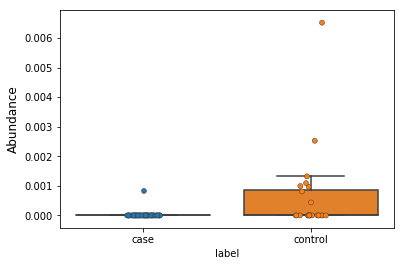

In [16]:
# Now we can plot the abundance of this bug
# We'll be using seaborn to plot the data because its functionality
# is infinitely better than matplotlib. But first, we have to get
# the data into tidy format.
def plot_otu_abundance(df, otu, x_axis_labels, list_of_samples):
    """
    Plots a boxplot with points for the values given in df[otu],
    where each boxplot contains data from each of the collection
    of samples in list_of_samples.
    
    Parameters
    ----------
    df : pandas DataFrame
        dataframe with values to plot
    otu : str
        OTU (or column name in df) to plot
    x_axis_labels : list of str
        the labels for each of your x-axis boxplots
    list_of_samples : list of lists
        which samples should go on each x-axis tick.
        e.g. this could be [control_samples, case_samples]
        
    Returns
    -------
    ax : axes handle of the plot you made
    """
    toplot = []
    i = 0
    for samples in list_of_samples:
        tmp = pd.DataFrame(
                {'abun': df.loc[samples, otu], 
                 'label': len(samples)*[x_axis_labels[i]]}
              )
        toplot.append(tmp)
        i += 1
    toplot = pd.concat(toplot)
    
    fig, ax = plt.subplots()
    sns.boxplot(data=toplot, x='label', y='abun',
                fliersize=0)
    sns.stripplot(data=toplot, x='label', y='abun',
                  jitter=True, linewidth=0.5)
    
    return fig, ax

fig, ax = plot_otu_abundance(df, most_sig_otu, 
                             ['case', 'control'], 
                             [case_samples, control_samples])

# Now you can change what the boxplot looks like using the Axes Handle
ax.set_ylabel('Abundance', fontsize='large')
# You can also save this figure
fig.savefig('my_figure.png')

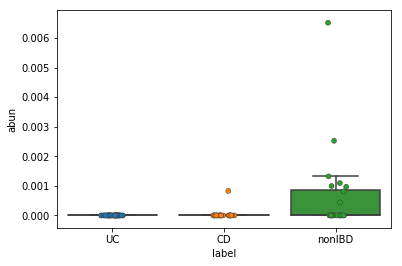

In [17]:
# You can also use this function to plot more than two groups
uc_samples = meta.query('DiseaseState == "UC"').index.tolist()
cd_samples = meta.query('DiseaseState == "CD"').index.tolist()

fig, ax = plot_otu_abundance(df, most_sig_otu, 
                             ['UC', 'CD', 'nonIBD'], 
                             [uc_samples, cd_samples, control_samples])


## Make a classifier

Here, we'll go through the basic steps involved in making a RandomForest classifier. It's pretty similar to the univariate tests!

In [18]:
# Initialize your classifier
rf = RandomForestClassifier(n_estimators=1000)

# Prepare the sample lists

# We'll keep the last 10 samples from both cases and
# controls for testing (note: this is not the right
# way to split your train and test sets, it should be
# random subsamples of the patients!)
train_smpls = control_samples[:-10] + case_samples[:-10]

X = df.loc[train_smpls].values
# Make a binary 0/1 label, where 1 corresponds to case_samples
# and 0 is all other samples
Y = [1 if i in case_samples else 0 for i in train_smpls]

# Train your classifier
rf = rf.fit(X, Y)

Note: you should really separate out your data so that only a subset of your samples are included in this training set. You can do this by changing which samples are in the `control_samples` and `case_samples` lists.

In [19]:
# See how well your classifier did

# Get the test data
test_smpls = control_samples[-10:] + case_samples[-10:]
Xtest = df.loc[test_smpls].values
Ytest = [1 if i in case_samples else 0 for i in test_smpls]

Let's calculate the area under the ROC curve using sklearn.metrics' roc_auc_score function.

This needs as input "Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers). For binary y_true, y_score is supposed to be the score of the class with greater label."

In [20]:
probabs = rf.predict_proba(Xtest)
roc_auc_score(Ytest, probabs[:, 1])

0.94000000000000006

And we can plot this ROC curve directly:

Text(0,0.5,'True positive rate')

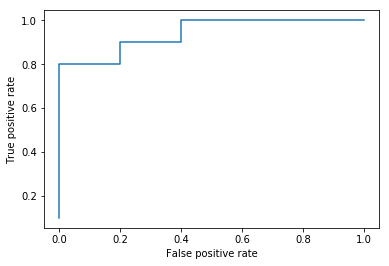

In [21]:
fpr, tpr, thresholds = roc_curve(Ytest, probabs[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')